# Volcanic composites with priors

In [1]:
import sys
import numpy as np
import pickle
import pandas as pd
import sys

from scipy import stats
from scipy import signal

import matplotlib.pyplot as plt

In [2]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [3]:
sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/')
import commonera_utils as ce_utils 

In [4]:
plt.rcParams['figure.dpi']=300

In [5]:
def recon_preprocess(var, time, anom_start, anom_end): 
    # Find indices to take anomalies over: 
    anom_ind = np.where((time<anom_end)&(time>=anom_start))
    
    var_2d = np.reshape(var,(var.shape[0],var.shape[1]*var.shape[2]))
    var_anom_2d = var_2d - np.nanmean(np.squeeze(var_2d[anom_ind,:]),axis=0)
    var_anom_mn = np.nanmean(var_anom_2d,axis=1)

    var_97_5 = np.percentile(var_anom_2d,97.5,axis=1)
    var_2_5 = np.percentile(var_anom_2d,2.5,axis=1)
    
    return var_2d, var_anom_2d, var_anom_mn , var_97_5, var_2_5

In [6]:
def load_recon_allit(output_dir,filename,niter,prox_loc=True):

    for it in range(niter):
        output_file = filename[:-5]+str(it)+'.pkl'

        if prox_loc is True: 
            [sic_lalo, tas_lalo, sic_ens_var, 
             nobs, sia_ens, sie_ens, recon_years, 
             Ye_assim, Ye_assim_coords, Xb_inflate, proxy_assim_loc] = load_recon(output_dir+output_file)          
        else: 
            [sic_lalo, tas_lalo, sic_ens_var, 
             nobs, sia_ens, sie_ens, recon_years, 
             Ye_assim, Ye_assim_coords, Xb_inflate] = load_recon(output_dir+output_file, prox_loc=False)

        if it is 0: 
            sic_lalo_allit = np.zeros((sic_lalo.shape[0],sic_lalo.shape[1],sic_lalo.shape[2],niter))
            tas_lalo_allit = np.zeros((tas_lalo.shape[0],tas_lalo.shape[1],tas_lalo.shape[2],niter))
            sic_ens_var_allit = np.zeros(niter)
            nobs_allit = np.zeros((nobs.shape[0],niter))
            sia_ens_allit = np.zeros((sia_ens.shape[0],sia_ens.shape[1],niter))
            sie_ens_allit = np.zeros((sie_ens.shape[0],sie_ens.shape[1],niter))
            Ye_assim_allit = np.zeros((Ye_assim.shape[0],Ye_assim.shape[1],niter))
            Ye_assim_coords_allit = np.zeros((Ye_assim_coords.shape[0],Ye_assim_coords.shape[1],niter))
            Xb_inflate_allit = np.zeros((Xb_inflate.shape[0],Xb_inflate.shape[1],niter))
            if prox_loc is True: 
                proxy_assim_loc_allit = {}

        sic_lalo_allit[:,:,:,it] = sic_lalo
        tas_lalo_allit[:,:,:,it] = tas_lalo
        sic_ens_var_allit[it] = niter
        nobs_allit[:,it] = nobs
        sia_ens_allit[:,:,it] = sia_ens
        sie_ens_allit[:,:,it] = sie_ens
        Ye_assim_allit[:,:,it] = Ye_assim
        Ye_assim_coords_allit[:,:,it] = Ye_assim_coords
        Xb_inflate_allit[:,:,it] = Xb_inflate
        if prox_loc is True: 
            proxy_assim_loc_allit['iter '+str(it)] = proxy_assim_loc
        
    if prox_loc is True:        
        return (sic_lalo_allit, tas_lalo_allit, sic_ens_var_allit, nobs_allit, 
                sia_ens_allit, sie_ens_allit, Ye_assim_allit, Ye_assim_coords_allit, 
                Xb_inflate_allit,recon_years, proxy_assim_loc_allit)
    else: 
        return (sic_lalo_allit, tas_lalo_allit, sic_ens_var_allit, nobs_allit, 
                sia_ens_allit, sie_ens_allit, Ye_assim_allit, Ye_assim_coords_allit, 
                Xb_inflate_allit,recon_years)

In [7]:
def load_recon(LOC, prox_loc=True):
    recon = pickle.load(open(LOC,'rb'))
    
    sic_lalo = recon['sic_lalo']
    tas_lalo = recon['tas_lalo']
    sic_ens_var = recon['sic_ens_var']
    nobs = recon['nobs']
    sia_ens = recon['sia_ens']
    sie_ens = recon['sie_ens']
    recon_years = recon['recon_years']
    Ye_assim = recon['Ye_assim']
    Ye_assim_coords = recon['Ye_assim_coords']
    Xb_inflate = recon['Xb_inflate'] 
    
    if prox_loc is True: 
        proxy_assim_loc = recon['proxy_assim_loc']
    
        return (sic_lalo, tas_lalo, sic_ens_var, nobs, sia_ens, sie_ens, recon_years, 
                Ye_assim, Ye_assim_coords, Xb_inflate, proxy_assim_loc)
    else: 
        return (sic_lalo, tas_lalo, sic_ens_var, nobs, sia_ens, sie_ens, recon_years, 
                Ye_assim, Ye_assim_coords, Xb_inflate)

In [8]:
def load_ccsm4_lm_regridded():
    ccsm4_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/CCSM4/CCSM4_last_millennium/'
    ccsm4_file = 'ccsm4_sic_sit_tas_20CRv2_850_1850_full.npz'

    ccsm4_lm = np.load(ccsm4_dir+ccsm4_file)

    ccsm4_truth_sic = ccsm4_lm['sic_ccsm4']
    ccsm4_truth_sit = ccsm4_lm['sit_ccsm4']
    ccsm4_truth_tas = ccsm4_lm['tas_ccsm4']
    ccsm4_truth_lat = ccsm4_lm['lat_ccsm4']
    ccsm4_truth_lon = ccsm4_lm['lon_ccsm4']
    
    return ccsm4_truth_tas, ccsm4_truth_sic, ccsm4_truth_sit, ccsm4_truth_lat, ccsm4_truth_lon

In [9]:
def load_mpi_lm_regridded():
    mpi_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/MPI/'
    mpi_file = 'mpi_sic_sit_tas_20CRv2_850_1850_full.npz'

    mpi_lm = np.load(mpi_dir+mpi_file)

    mpi_truth_sic = mpi_lm['sic_mpi']
    mpi_truth_sit = mpi_lm['sit_mpi']
    mpi_truth_tas = mpi_lm['tas_mpi']
    mpi_truth_lat = mpi_lm['lat_mpi']
    mpi_truth_lon = mpi_lm['lon_mpi']
    
    return mpi_truth_tas, mpi_truth_sic, mpi_truth_sit, mpi_truth_lat, mpi_truth_lon

In [10]:
anom_start = 850
anom_end = 1850

## Load priors: 

In [11]:
[ccsm4_truth_tas, ccsm4_truth_sic, 
 ccsm4_truth_sit,
 ccsm4_truth_lat, ccsm4_truth_lon] = load_ccsm4_lm_regridded()

ccsm4_truth_time = np.arange(850,1851,1)

In [12]:
[sia_nh_ccsm4_truth, sie_nh_ccsm4_truth, 
 sia_nh_ccsm4_truth_anom, sie_nh_ccsm4_truth_anom,
 sia_sh_ccsm4_truth, sie_sh_ccsm4_truth, 
 sia_sh_ccsm4_truth_anom, 
 sie_sh_ccsm4_truth_anom] = ce_utils.calc_lm_tot_si(ccsm4_truth_sic,ccsm4_truth_lat, 
                                                    ccsm4_truth_time, anom_start, anom_end)

In [13]:
[mpi_truth_tas, mpi_truth_sic, 
 mpi_truth_sit,
 mpi_truth_lat, mpi_truth_lon] = load_mpi_lm_regridded()

mpi_time = np.arange(850,1850,1)

In [14]:
[sia_nh_mpi, sie_nh_mpi, 
 sia_nh_mpi_anom, sie_nh_mpi_anom,
 sia_sh_mpi, sie_sh_mpi, 
 sia_sh_mpi_anom, sie_sh_mpi_anom] = ce_utils.calc_lm_tot_si(mpi_truth_sic,mpi_truth_lat, 
                                                             mpi_time, anom_start, anom_end)

## Load reconstructions:

In [15]:
output_dir_ccsm4 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/ccsm4/'
#output_file_ccsm4 = 'sic_ccsm4_anrecon_0_2000_pages2kv2_inf2_6_loc15000_iter0.pkl'
output_file_ccsm4 = 'sic_ccsm4_anrecon_revisions1_0_2000_pages2kv2_inf2_6_loc15000_iter0.pkl'

niter = 10

[sic_lalo_allit_ccsm4, tas_lalo_allit_ccsm4, sic_ens_var_allit_ccsm4, 
 nobs_allit_ccsm4, sia_ens_allit_ccsm4, sie_ens_allit_ccsm4, Ye_assim_allit_ccsm4, 
 Ye_assim_coords_allit_ccsm4, Xb_inflate_allit_ccsm4, recon_years_ccsm4, 
 proxy_assim_loc_allit_ccsm4] = load_recon_allit(output_dir_ccsm4,output_file_ccsm4,niter)

In [16]:
[sie_ens_allit_2d_ccsm4, 
 sie_ens_anom_allit_ccsm4, 
 sie_ensmn_anom_allit_ccsm4, 
 sie_97_5_allit_ccsm4, 
 sie_2_5_allit_ccsm4] = recon_preprocess(sie_ens_allit_ccsm4, np.array(recon_years_ccsm4), anom_start, anom_end)

In [17]:
output_dir_mpi = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/mpi/'
#output_file_mpi = 'sic_mpi_anrecon_0_2000_pages2kv2_inf1_8_loc15000_iter0.pkl'
output_file_mpi = 'sic_mpi_anrecon_revisions1_0_2000_pages2kv2_inf1_8_loc15000_iter0.pkl'

[sic_lalo_allit_mpi, tas_lalo_allit_mpi, sic_ens_var_allit_mpi, 
 nobs_allit_mpi, sia_ens_allit_mpi, sie_ens_allit_mpi, Ye_assim_allit_mpi, 
 Ye_assim_coords_allit_mpi, Xb_inflate_allit_mpi, recon_years, 
 proxy_assim_loc_allit_mpi] = load_recon_allit(output_dir_mpi,output_file_mpi,niter)

In [18]:
[sie_ens_allit_2d_mpi, 
 sie_ens_anom_allit_mpi, 
 sie_ensmn_anom_allit_mpi, 
 sie_97_5_allit_mpi, 
 sie_2_5_allit_mpi] = recon_preprocess(sie_ens_allit_mpi, np.array(recon_years), anom_start, anom_end)

## Load volcanic forcing data (Sigl et al 2015):

In [19]:
sigl_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/Sigl2015/sigl_etal_2015_fig3_data.csv'

sigl_data = pd.read_csv(sigl_dir)
sigl_data.head()

,Start Year,Global forcing (40 largest),Start Year .1,Global forcing (tropical),Start Year .2,Global forcing (NH),Start Year .3,Global forcing (SH)
0,BCE/CE,W [m-2],BCE/CE,W [m-2],BCE/CE,W [m-2],BCE/CE,W [m-2]
1,-426,-35.6,1992,-6.5,1957,-1.0,1979,-0.4
2,1258,-32.8,1982,-0.4,1947,-0.6,1931,-0.3
3,-44,-23.2,1968,-0.4,1926,-1.8,1890,-0.4
4,1458,-20.6,1964,-3.8,1925,-1.0,1887,-0.8


In [20]:
sigl_nh_volc_forc = np.zeros((116))
sigl_nh_volc_yrs = np.zeros((116))

for i in range(116):
    sigl_nh_volc_yrs[i] = int(sigl_data['Start Year .2'][i+1])
    sigl_nh_volc_forc[i] = float(sigl_data['Global forcing (NH)'][i+1])
    
sigl_nh_full_forc = np.zeros((2001))

for iyr,yr in enumerate(sigl_nh_volc_yrs):
    sigl_nh_full_forc[int(yr)] = sigl_nh_volc_forc[iyr]

In [21]:
sigl_trop_volc_forc = np.zeros((62))
sigl_trop_volc_yrs = np.zeros((62))

for i in range(62):
    sigl_trop_volc_yrs[i] = int(sigl_data['Start Year .1'][i+1])
    sigl_trop_volc_forc[i] = float(sigl_data['Global forcing (tropical)'][i+1])
    
sigl_trop_full_forc = np.zeros((2001))

for iyr,yr in enumerate(sigl_trop_volc_yrs):
    sigl_trop_full_forc[int(yr)] = sigl_trop_volc_forc[iyr]

## Composite analysis: 
### Extract forcing and years of 40 largest eruptions: 

In [22]:
sigl_40lg_forc = []
sigl_40lg_yrs = []

for i in range(40): 
    if (int(sigl_data['Start Year '][i+1])>=0)&(int(sigl_data['Start Year '][i+1])<=1980):
        sigl_40lg_forc.append(float(sigl_data['Global forcing (40 largest)'][i+1]))
        sigl_40lg_yrs.append(int(sigl_data['Start Year '][i+1]))
        
sigl_40lg_forc_full = np.zeros((2001))        
for y,yr in enumerate(sigl_40lg_yrs):
    sigl_40lg_forc_full[yr] = np.array(sigl_40lg_forc)[y]

In [23]:
sigl_40lg_yr_trop = (set(sigl_40lg_yrs) - set(sigl_nh_volc_yrs))
sigl_40lg_yr_nh = (set(sigl_40lg_yrs) - set(sigl_trop_volc_yrs))

len(sigl_40lg_yr_trop),len(sigl_40lg_yr_nh)

(24, 7)

### Filter out eruptions that are within 10 years of each other: 

In [24]:
volc_40time = np.sort(sigl_40lg_yrs)
volc_time_diff = np.array(volc_40time)[1:] - np.array(volc_40time)[:-1] 
volc_time_diff

array([ 82,  97, 167, 103,   4,  34,  52,  56,  68,  67,  99,  23, 169,
        63,  20,  39,  28,  18,  10,  59, 108,   5, 143,  40,  54,  88,
        26,   6,  17,   4])

In [25]:
volc_40_time_norep = []

for t in range(len(volc_time_diff)):
    if volc_time_diff[t] >10:
        volc_40_time_norep.append(volc_40time[t])
        
volc_40_time_norep.append(volc_40time[-1])

In [26]:
sie_ens_allit_2d_ccsm4.shape

(2000, 2000)

In [27]:
lm_volc_40 = [i for i in volc_40_time_norep if i>850]

nvolc = len(lm_volc_40)
sie_allit_volc_ccsm4 = np.zeros((26,nvolc))
sie_allit_volc_mpi = np.zeros((26,nvolc))
sie_allit_ccsm4_recon= np.zeros((26,nvolc,2000))
sie_allit_mpi_recon= np.zeros((26,nvolc,2000))

for i,volc_yr in enumerate(lm_volc_40[:-1]):
    lm_volc_yr = volc_yr - 850
    mn_ccsm4 = np.nanmean(sie_nh_ccsm4_truth_anom[int(lm_volc_yr-5):lm_volc_yr],axis=0) 
    sie_allit_volc_ccsm4[:,i] = sie_nh_ccsm4_truth_anom[int(lm_volc_yr-5):int(lm_volc_yr+21)] - mn_ccsm4
    
    mn_mpi = np.nanmean(sie_nh_mpi_anom[int(lm_volc_yr-5):lm_volc_yr],axis=0) 
    sie_allit_volc_mpi[:,i] = sie_nh_mpi_anom[int(lm_volc_yr-5):int(lm_volc_yr+21)] - mn_mpi
    
    mn_ccsm4_recon = np.nanmean(sie_ens_allit_2d_ccsm4[int(volc_yr-5):volc_yr,:],axis=0) 
    sie_allit_ccsm4_recon[:,i,:] = sie_ens_allit_2d_ccsm4[int(volc_yr-5):int(volc_yr+21),:] - mn_ccsm4_recon
    
    mn_mpi_recon = np.nanmean(sie_ens_allit_2d_mpi[int(volc_yr-5):volc_yr,:],axis=0) 
    sie_allit_mpi_recon[:,i,:] = sie_ens_allit_2d_mpi[int(volc_yr-5):int(volc_yr+21),:] - mn_mpi_recon

# sie_allit_volc_2d = np.reshape(sie_allit_volc,(26,nvolc*2000))
# sie_enmn_allvolc_2d = np.nanmean(sie_allit_volc_2d,axis=1)

In [28]:
sie_allit_volc_2d = np.reshape(sie_allit_ccsm4_recon,(26,nvolc*2000))
sie_enmn_allvolc_ccsm4_recon = np.nanmean(sie_allit_volc_2d,axis=1)

sie_allit_volc_2d_mpi = np.reshape(sie_allit_mpi_recon,(26,nvolc*2000))
sie_enmn_allvolc_mpi_recon = np.nanmean(sie_allit_volc_2d_mpi,axis=1)

### Significance testing: 

In [29]:
# sie_enmn_allvolc = np.nanmean(sie_allit_volc,axis=2)

stat, p = stats.ttest_1samp(sie_allit_volc_mpi,0, axis=1)
ttest_sig_mpi = (p<0.05)
p

array([6.46971673e-01, 4.00444291e-01, 5.62510242e-01, 9.29989242e-01,
       6.84637333e-01, 3.14251497e-01, 2.47242594e-02, 1.12664534e-02,
       4.81984028e-03, 1.58255894e-03, 3.85854778e-04, 3.03381321e-03,
       1.45258943e-02, 2.67557547e-01, 6.99761653e-01, 9.88184968e-01,
       9.38657079e-01, 9.39295812e-01, 9.75324663e-01, 9.17841977e-01,
       5.96525074e-01, 7.23082006e-01, 8.00018716e-01, 4.29747899e-01,
       7.83672156e-01, 9.75988740e-01])

In [30]:
# sie_enmn_allvolc = np.nanmean(sie_allit_volc,axis=2)

stat, p = stats.ttest_1samp(sie_allit_volc_ccsm4,0, axis=1)
ttest_sig_ccsm4 = (p<0.05)
p

array([0.90933204, 0.56234707, 0.59310709, 0.60666531, 0.38340814,
       0.81781072, 0.69529814, 0.95472045, 0.26755899, 0.42207332,
       0.62581905, 0.86312822, 0.67768408, 0.39691673, 0.36307504,
       0.1113161 , 0.19138703, 0.01552492, 0.0177143 , 0.27141901,
       0.01489045, 0.05076793, 0.04579982, 0.25963481, 0.05984819,
       0.11299446])

In [31]:
sie_enmn_allvolc_mpi = np.nanmean(sie_allit_mpi_recon,axis=2)

stat_mpi, p_mpi = stats.ttest_1samp(sie_enmn_allvolc_mpi,0, axis=1)
ttest_sig_mpi_recon = (p_mpi<0.05)
p_mpi

array([0.59808655, 0.20993969, 0.54837075, 0.53529251, 0.63662803,
       0.00397291, 0.00583646, 0.01946357, 0.00183406, 0.05748972,
       0.00259029, 0.07158391, 0.06921926, 0.12881804, 0.89512379,
       0.58541125, 0.43062704, 0.647294  , 0.74482109, 0.56500579,
       0.6451213 , 0.17448506, 0.67661716, 0.57886625, 0.51527955,
       0.8959129 ])

In [32]:
sie_enmn_allvolc = np.nanmean(sie_allit_ccsm4_recon,axis=2)

stat, p = stats.ttest_1samp(sie_enmn_allvolc,0, axis=1)
ttest_sig_ccsm4_recon = (p<0.05)
p

array([0.86834659, 0.64635428, 0.3432612 , 0.26170611, 0.62290871,
       0.00223141, 0.00157854, 0.02077913, 0.00153293, 0.13768994,
       0.00345997, 0.14849986, 0.11585257, 0.18992206, 0.60444903,
       0.23113392, 0.65925792, 0.72875666, 0.78854722, 0.68628547,
       0.7486024 , 0.30938801, 0.52233419, 0.40232888, 0.65797333,
       0.97583102])

In [33]:
sigtest_yrs = np.random.randint(0,1000,size=500)

In [34]:
sz = 26
sie_allit_randcomp_ccsm4_ensmn = np.zeros((1000,26))
sie_allit_randcomp_mpi_ensmn = np.zeros((1000,26))

for rn in range(1000):
    sigtest_yrs = np.random.randint(5,1000-21,size=sz)
    sie_allit_randcomp_ccsm4 = np.zeros((26,sz))
    sie_allit_randcomp_mpi = np.zeros((26,sz))

    for i,volc_yr in enumerate(sigtest_yrs):
        mn_ccsm4 = np.nanmean( sie_nh_ccsm4_truth_anom[int(volc_yr-5):volc_yr],axis=0) 
        sie_allit_randcomp_ccsm4[:,i] =  sie_nh_ccsm4_truth_anom[int(volc_yr-5):int(volc_yr+21)] - mn_ccsm4
        
        mn_mpi = np.nanmean( sie_nh_ccsm4_truth_anom[int(volc_yr-5):volc_yr],axis=0) 
        sie_allit_randcomp_mpi[:,i] =  sie_nh_mpi_anom[int(volc_yr-5):int(volc_yr+21)] - mn_mpi

    sie_allit_randcomp_ccsm4_ensmn[rn, :] = np.nanmean(sie_allit_randcomp_ccsm4,axis=1)
    sie_allit_randcomp_mpi_ensmn[rn, :] = np.nanmean(sie_allit_randcomp_mpi,axis=1)

In [35]:
sie_allit_randcomp_ccsm4_ensmn_97_5 = np.percentile(sie_allit_randcomp_ccsm4_ensmn,97.5,axis=0)
sie_allit_randcomp_ccsm4_ensmn_2_5 = np.percentile(sie_allit_randcomp_ccsm4_ensmn,2.5,axis=0)

sie_allit_randcomp_mpi_ensmn_97_5 = np.percentile(sie_allit_randcomp_mpi_ensmn,97.5,axis=0)
sie_allit_randcomp_mpi_ensmn_2_5 = np.percentile(sie_allit_randcomp_mpi_ensmn,2.5,axis=0)

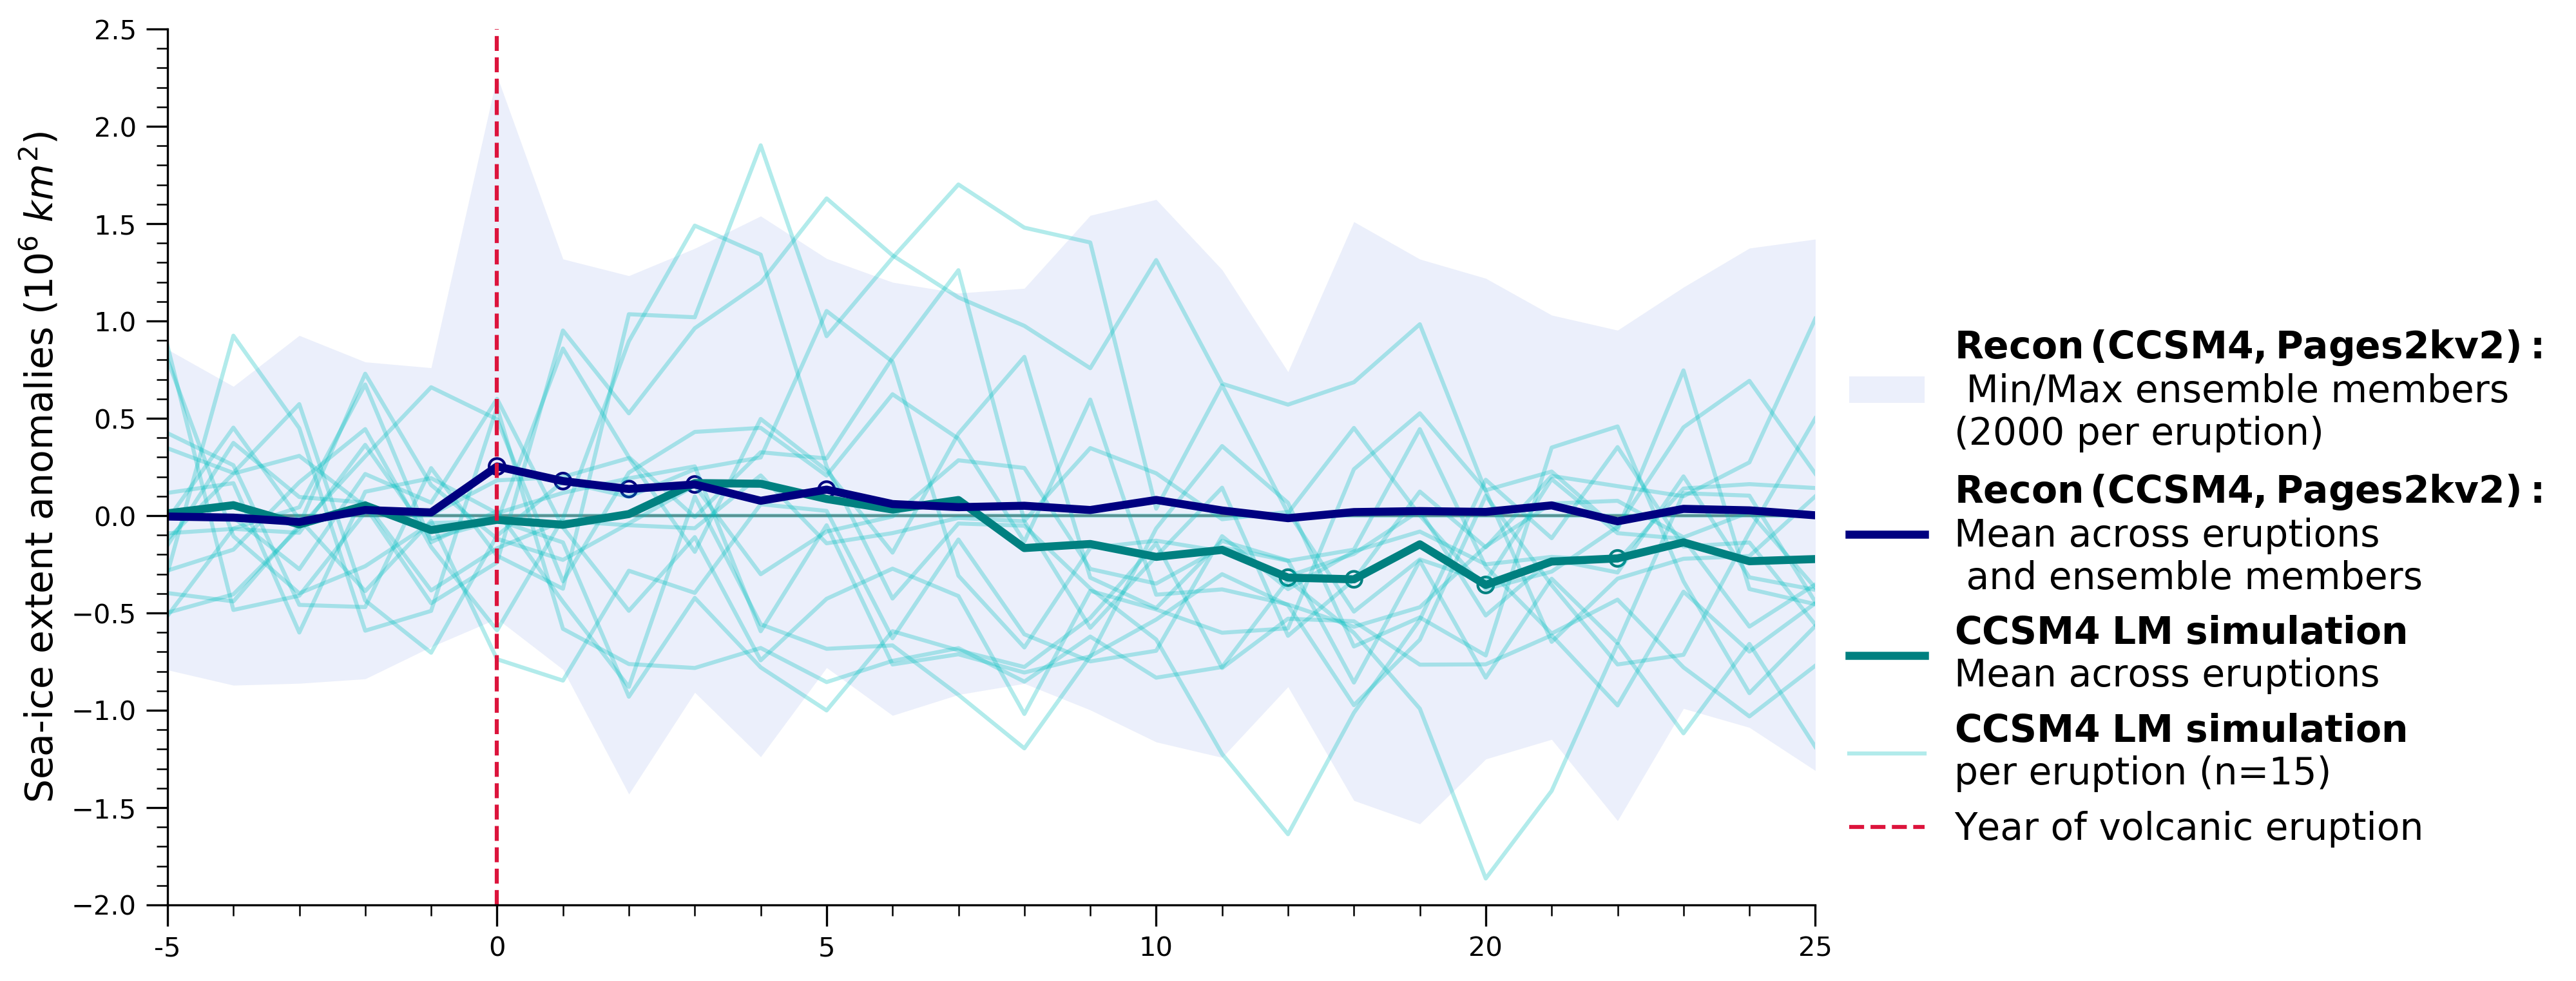

In [51]:
fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot(111)
plt.axhline(0, linestyle='-',color='gray', linewidth=1)

# plt.fill_between(np.arange(0,26,1),sie_allit_randcomp_ccsm4_ensmn_2_5, sie_allit_randcomp_ccsm4_ensmn_97_5,
#                  color='gray',alpha=0.4 ,lw=0.01)
plt.fill_between(np.arange(0,26,1),np.max(sie_allit_volc_2d,axis=1),
                            np.min(sie_allit_volc_2d,axis=1),
                            color='royalblue',alpha=0.1 ,lw=0.01, 
                            label=r'$\bf{Recon\,(CCSM4, Pages2kv2):}$'+'\n Min/Max ensemble members \n(2000 per eruption)')

for i in range(nvolc):
    if i is 0: 
        lab = lab = (r'$\bf{CCSM4}$'+' '+r'$\bf{LM}$'+' '+r'$\bf{simulation}$'+
               '\nper eruption (n=15)')
    else: 
        lab = ''
    plt.plot(np.arange(0,26,1),sie_allit_volc_ccsm4[:,i], color='c', alpha=0.3,
             label=lab, linewidth=1.5)
#     plt.plot(np.arange(0,26,1),np.nanmean(sie_allit_ccsm4_recon,axis=2)[:,i], color='royalblue', alpha=0.3,
#              label=lab, linewidth=1.5)
plt.plot(np.arange(0,26,1),np.nanmean(sie_allit_volc_ccsm4,axis=1), 
         color='teal', linewidth=3, label=(r'$\bf{CCSM4}$'+' '+r'$\bf{LM}$'+' '+r'$\bf{simulation}$'+
                                                    '\nMean across eruptions'))
plt.plot(np.arange(0,26,1),sie_enmn_allvolc_ccsm4_recon, 
         color='navy', linewidth=3, 
        label=r'$\bf{Recon\,(CCSM4, Pages2kv2):}$'+'\nMean across eruptions \n and ensemble members')

for yr in range(26):
    if ttest_sig_ccsm4[yr] == True: 
        plt.scatter(yr,np.nanmean(sie_allit_volc_ccsm4,axis=1)[yr], color='teal',
                    marker='o', s=35, facecolors='none')
for yr in range(26):
    if ttest_sig_ccsm4_recon[yr] == True: 
        plt.scatter(yr,sie_enmn_allvolc_ccsm4_recon[yr], color='navy',
                    marker='o', s=35, facecolors='none')

x = [0,5,10,15,20,25,30]
labels = [-5,0,5,10,20,25]
plt.xticks(x,labels)
#plt.xlabel('Years pre/post eruption (CE)', fontsize=14)
plt.ylabel('Sea-ice extent anomalies (10$^{6}$ $km^2$)', fontsize=14)

ax = plt.gca()
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.axvline(5,color='crimson', linestyle='--', linewidth=1.5, label='Year of volcanic eruption')

handles, labels = plt.gca().get_legend_handles_labels()
h = [handles[4],handles[2],handles[1],handles[0],handles[3]]
l = [labels[4],labels[2],labels[1],labels[0],labels[3]]

lgd = ax.legend(h,l,bbox_to_anchor=(1.0, 0.7),frameon=False,fontsize=14)
plt.xlim(0,25)
plt.ylim(-2,2.5)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'volc_prior_recon_comp_ccsm4_sigl_2015_large_norep_composite.png'
fig.savefig(savedir+savename,  bbox_inches='tight')

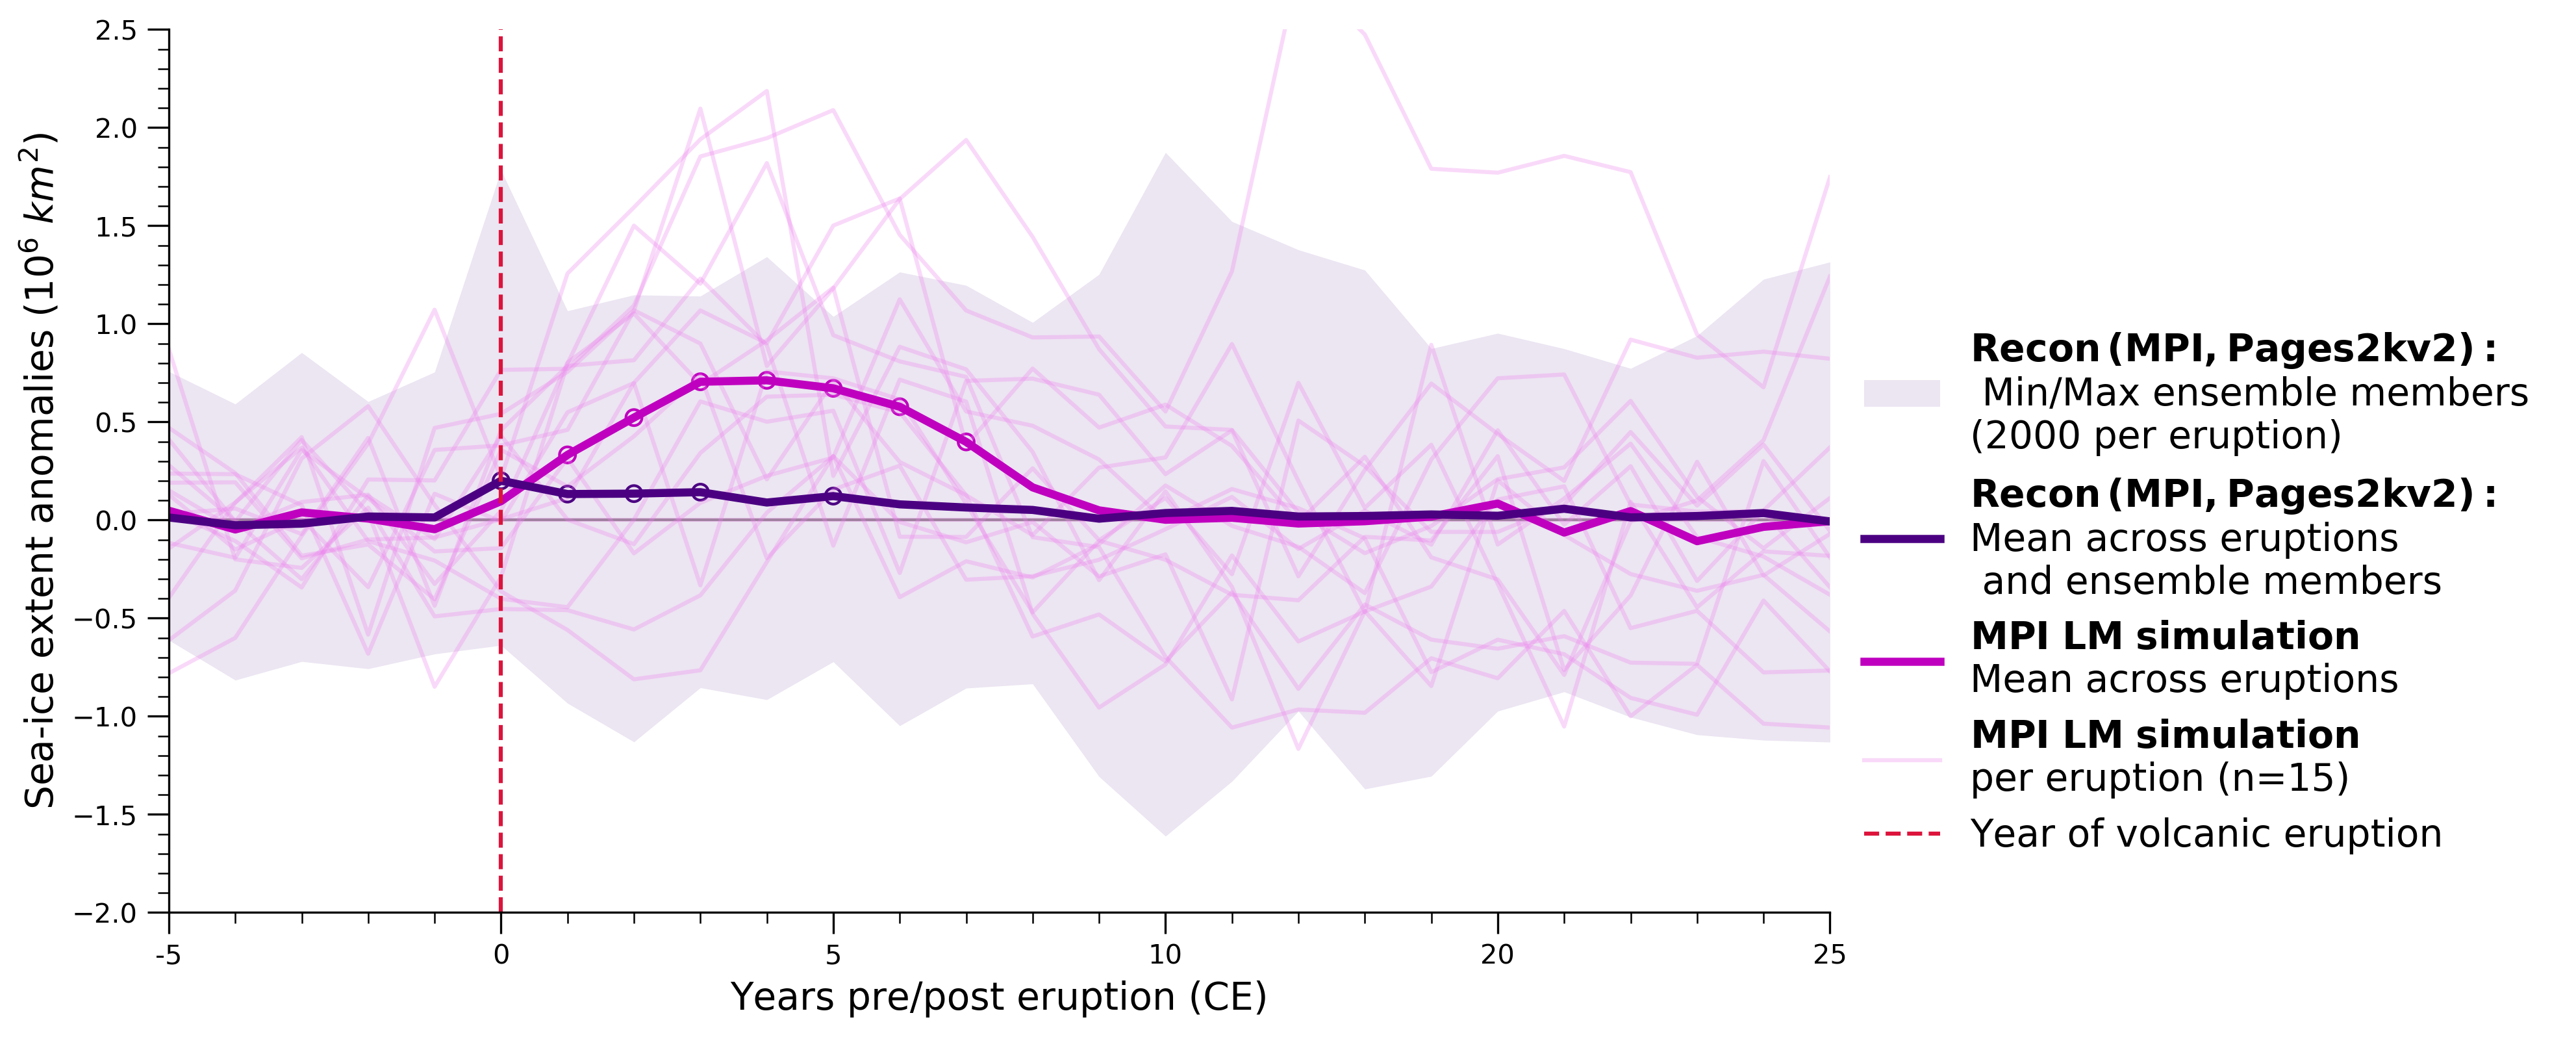

In [52]:
fig = plt.figure(figsize=(11,6))
plt.axhline(0, linestyle='-',color='gray', linewidth=1)

plt.fill_between(np.arange(0,26,1),np.max(sie_allit_volc_2d_mpi,axis=1),
                            np.min(sie_allit_volc_2d_mpi,axis=1),
                            color='indigo',alpha=0.1 ,lw=0.01, 
                            label=r'$\bf{Recon\,(MPI, Pages2kv2):}$'+'\n Min/Max ensemble members \n(2000 per eruption)')

for i in range(nvolc):
    if i is 0: 
        lab = lab = (r'$\bf{MPI}$'+' '+r'$\bf{LM}$'+' '+r'$\bf{simulation}$'+
               '\nper eruption (n=15)')
    else: 
        lab = ''
    plt.plot(np.arange(0,26,1),sie_allit_volc_mpi[:,i], color='violet', alpha=0.3,
             label=lab, linewidth=1.5)
#     plt.plot(np.arange(0,26,1),np.nanmean(sie_allit_ccsm4_recon,axis=2)[:,i], color='royalblue', alpha=0.3,
#              label=lab, linewidth=1.5)
plt.plot(np.arange(0,26,1),np.nanmean(sie_allit_volc_mpi,axis=1), 
         color='m', linewidth=3, label=(r'$\bf{MPI}$'+' '+r'$\bf{LM}$'+' '+r'$\bf{simulation}$'+
                                                    '\nMean across eruptions'))
plt.plot(np.arange(0,26,1),sie_enmn_allvolc_mpi_recon, 
         color='indigo', linewidth=3, 
        label=r'$\bf{Recon\,(MPI, Pages2kv2):}$'+'\nMean across eruptions \n and ensemble members')

for yr in range(26):
    if ttest_sig_mpi[yr] == True: 
        plt.scatter(yr,np.nanmean(sie_allit_volc_mpi,axis=1)[yr], color='m',
                    marker='o', s=35, facecolors='none')
for yr in range(26):
    if ttest_sig_mpi_recon[yr] == True: 
        plt.scatter(yr,sie_enmn_allvolc_mpi_recon[yr], color='indigo',
                    marker='o', s=35, facecolors='none')

x = [0,5,10,15,20,25,30]
labels = [-5,0,5,10,20,25]
plt.xticks(x,labels)
plt.xlabel('Years pre/post eruption (CE)', fontsize=14)
plt.ylabel('Sea-ice extent anomalies (10$^{6}$ $km^2$)', fontsize=14)

ax = plt.gca()
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.axvline(5,color='crimson', linestyle='--', linewidth=1.5, label='Year of volcanic eruption')

handles, labels = plt.gca().get_legend_handles_labels()
h = [handles[4],handles[2],handles[1],handles[0],handles[3]]
l = [labels[4],labels[2],labels[1],labels[0],labels[3]]

plt.legend(h,l,bbox_to_anchor=(1.0, 0.7), frameon=False,fontsize=14)
plt.xlim(0,25)
plt.ylim(-2,2.5)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'volc_prior_recon_comp_mpi_sigl_2015_large_norep_composite.png'
fig.savefig(savedir+savename,  bbox_inches='tight')